## Install the package dependencies before running this notebook

In [1]:
import torch
import os, os.path 
import pickle
from glob import glob
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim import Rprop, Adam
import math
import time
torch.set_default_dtype(torch.float)

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

True

## Create a Torch.Dataset class for the training dataset

In [2]:
ROOT_PATH = ""

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    #outputs = None
    outputs = np.zeros((inputs.shape[0], 60, 2))
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        
          

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data


## Create a DataLoader class for training

In [6]:
batch_sz = 4 # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)


## Sample a batch of data and visualize 

In [8]:
import matplotlib.pyplot as plt
import random
batch_sz = 4
sample = {"austin":4}
def show_sample_batch(sample, sample_batch ):
    """visualize the trajectory for a batch of samples"""

    inp_for_test = get_input_tensor(sample, "train")
    
    inp,out = sample_batch 
    
    pred = model(inp_for_test.to(device).float()).cpu().detach().numpy().reshape(inp_for_test.shape[0],60,2)
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
   
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        
        axs[i].scatter(inp[i,:,0], inp[i,:,1], alpha=0.5)
        axs[i].scatter(out[i,:,0], out[i,:,1], alpha=0.2)
        
        axs[i].scatter(pred[i,:,0], pred[i,:,1], alpha=0.2)
        axs[i].legend(['input','output','prediction'])

        
for i_batch, sample_batch in enumerate(train_loader):
    
    inp, out = sample_batch
    show_sample_batch(sample,sample_batch)
    break


In [9]:
#feature engineering
# Calculate the distance between two points
def calc_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Calculate the velocity between two points
def velocity(a,b):
    return [(b[0] - a[0])/0.1, (b[1] - a[1]/0.1) ]

def speed(a,b):
    dist = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    return dist/5
# encoder city

def onehot_city(city):
    if city == "austin":
        return [1,0,0,0,0,0]
    elif city == "miami":
        return [0,1,0,0,0,0]
    elif city == "pittsburgh":
        return [0,0,1,0,0,0]
    elif city == "dearborn":
        return [0,0,0,1,0,0]
    elif city == "washington-dc":
        return [0,0,0,0,1,0]
    else:
        return [0,0,0,0,0,1]    

In [10]:
#get tensor x
def get_input_tensor(cities_dataset, split, val = False):
    X = []
    for city in cities_dataset:
        print("input x: " + "Processing city", city)
        dataset = ArgoverseDataset(city = city, split = split)
        
        for i in range(cities_dataset[city]):
            
            if val is True:
                i+= cities_dataset[city]
            # city feature  
            x1 = onehot_city(city)
            X.extend(x1)
            
            # coordinate feature
            inpu, _ = dataset[i]
            
            x2 = list(inpu.reshape(100))
            X.extend(x2)
            
            # distance
            for j in range(inpu.shape[0]):
                if j == 0:
                    dist = calc_distance(inpu[j], inpu[j])
                else: 
                    dist = calc_distance(inpu[j-1], inpu[j])
                X.append(dist)
            #dist = calc_distance(inpu[0], inpu[-1])
            #X.append(dist)
            
            #vel
            for j in range(inpu.shape[0]):
                if j == 0:
                    vel_x , vel_y = velocity(inpu[j], inpu[j])
                else:
                    vel_x , vel_y = velocity(inpu[j-1], inpu[j])
                
                X.append(vel_x)
                X.append(vel_y)
            
        
            
            feat_num_in =  len(x1)+len(x2) + 50 + 100
            
    tensor_x = torch.tensor(X).reshape(sum(cities_dataset.values()), feat_num_in)  
    return tensor_x

#get tensor y 
def get_out_tensor(cities_dataset, split, val = False):
    Y = []
    feat_num_out = 120
    for city in cities_dataset:
        
        dataset = ArgoverseDataset(city = city, split = split)
        
        for i in range(cities_dataset[city]):
            if val is True:
                i+= cities_dataset[city]
            
            # coordinate feature
            _, out = dataset[i]
            
            y = list(out.reshape(120))
            Y.extend(y)
            
            
    
    tensor_y = torch.tensor(Y).reshape(sum(cities_dataset.values()), feat_num_out)
    return tensor_y
            

In [11]:
cities_train = {"austin":40000, 
               "miami":50000, 
                "pittsburgh":40000, 
                "dearborn":22000, 
                "washington-dc":23000, 
                "palo-alto":11000}
# train dataset
#cities_train = city_data('miami')
train_tensor_x = get_input_tensor(cities_train, "train").to(device)
train_tensor_y = get_out_tensor(cities_train, "train").to(device)
train_dataset = TensorDataset(train_tensor_x,train_tensor_y)

input x: Processing city austin
input x: Processing city miami
input x: Processing city pittsburgh
input x: Processing city dearborn
input x: Processing city washington-dc
input x: Processing city palo-alto


In [12]:
cities_val = {"austin":3041, 
               "miami":5029, 
                "pittsburgh":3544, 
                "dearborn":2465, 
                "washington-dc":2744, 
                "palo-alto":993}

# validation dataset 
val_tensor_x  = get_input_tensor(cities_val, "train", val = True).to(device)
val_tensor_y = get_out_tensor(cities_val, "train", val = True).to(device)
val_dataset = TensorDataset(val_tensor_x, val_tensor_y)
val_dataloader = DataLoader(val_dataset, batch_size = 2000)

input x: Processing city austin
input x: Processing city miami
input x: Processing city pittsburgh
input x: Processing city dearborn
input x: Processing city washington-dc
input x: Processing city palo-alto


### Build, Train model and Evaluate 

In [13]:
# Model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #6 cities + 5s postion(x,y) + 5s velocity(x,y) + two points(x,y) distance
        self.encoder = nn.Sequential(
            nn.Linear(6+100+100+50, 2048),
            nn.Linear(2048, 4096),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.Linear(2048, 120),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
# Train function
def train(model, x, y, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x.float())
    loss = criterion(output, y.float())
    loss.backward()
    optimizer.step()
    return loss, output

# get val loss function
def getValLoss(model, criterion):
    total_loss = 0
    batch_count = 0
    for i_batch, sample_batch in enumerate(val_dataloader):
        x_val, y_val = sample_batch[0], sample_batch[1]
        output = model(x_val.float())
        total_loss += criterion(output, y_val.float()).item()
        batch_count +=1
    return total_loss/batch_count

In [15]:
model = Net().to(device)
optm = Adam(model.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones = [10,20,40], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, mode='min', factor=0.1, patience=2, eps=1e-7, verbose=True)
criterion = nn.MSELoss().to(device)


all_train_loss = []
all_val_loss = []

EPOCH_LENGTH = 150
BATCH_SIZE = 64

start = time.time()
for epoch in range(EPOCH_LENGTH):
    total_loss  = 0
    batch_count = 0
    
    my_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True) 
    for i_batch, (x_train, y_train) in enumerate(my_dataloader):
        loss, _ = train(model, x_train, y_train, optm, criterion)
        total_loss += loss.item()
        batch_count += 1
    
    #calculate train loss and val loss
    train_loss = total_loss/batch_count
    val_loss = getValLoss(model, criterion)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    
    # log 
    print('Time{}, epoch {}, Train loss: {}, Val loss: {}'.format(timeSince(start), epoch, train_loss, val_loss))
   
    scheduler.step(train_loss)


Time0m 21s, epoch 0, Train loss: 19036.84438777749, Val loss: 4660.442864312066
Time0m 42s, epoch 1, Train loss: 1921.7546793488568, Val loss: 257.0731777615017
Time1m 3s, epoch 2, Train loss: 2512.280532960265, Val loss: 274.14171346028644
Time1m 24s, epoch 3, Train loss: 789.8589764120327, Val loss: 14318.753634982639
Time1m 45s, epoch 4, Train loss: 1445.234148776773, Val loss: 208.75865258110895
Time2m 5s, epoch 5, Train loss: 1281.0809798593327, Val loss: 256.9277589586046
Time2m 26s, epoch 6, Train loss: 962.2857453431876, Val loss: 150.60929446750217
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Time2m 47s, epoch 7, Train loss: 59.26942609124959, Val loss: 72.75521172417535
Time3m 8s, epoch 8, Train loss: 66.7296985735137, Val loss: 104.13013882107205
Time3m 29s, epoch 9, Train loss: 67.72108875913722, Val loss: 48.70966254340278
Time3m 50s, epoch 10, Train loss: 60.84561345271323, Val loss: 62.21761152479384
Epoch    11: reducing learning rate of group 0 to 1.00

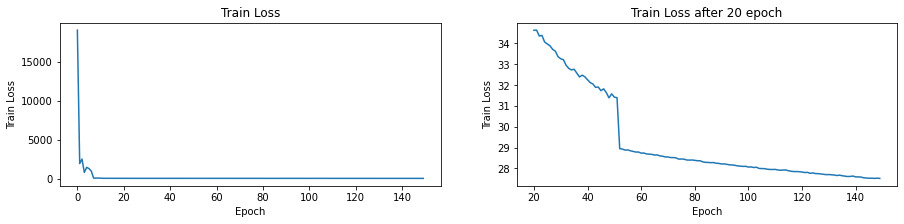

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(range(0,150), all_train_loss)
axs[0].set_ylabel("Train Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Train Loss")
axs[1].plot(range(20,150), all_train_loss[20:])
axs[1].set_ylabel("Train Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Train Loss after 20 epoch")
plt.show()

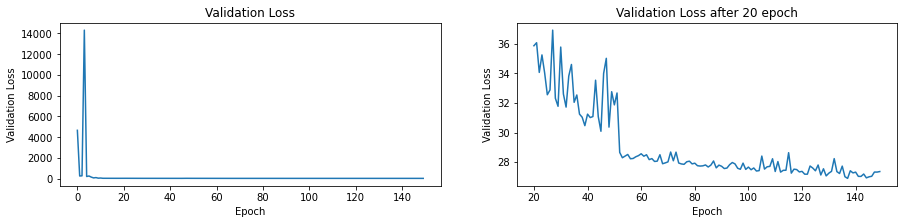

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(range(0,150), all_val_loss)
axs[0].set_ylabel("Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_title("Validation Loss")
axs[1].plot(range(20,150), all_val_loss[20:])
axs[1].set_ylabel("Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_title("Validation Loss after 20 epoch")
plt.show()

## Examining the submission format

In [18]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def city_data(city_name):
    if city_name == "austin":
        return {'austin':6325}
    elif city_name == "miami":
        return {'miami':7971}
    elif city_name == "pittsburgh":
        return {'pittsburgh': 6361}
    elif city_name == "dearborn":
        return {'dearborn':3671}
    elif city_name == "washington-dc":
        return {'washington-dc':3829}
    else:
        return {'palo-alto':1686}

num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]

test_data = [6325, 7971, 6361, 3671, 3829, 1686]
for city_name in cities:

    #test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    
    city_test = city_data(city_name)
    test_x = get_input_tensor(city_test, "test").to(device)
    outcome = model(test_x.float())
    test_pred_arr =outcome.cpu().detach().numpy()
    print(test_pred_arr.shape)
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_x.shape[0], num_pred_steps * 2))

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]


input x: Processing city austin
(6325, 120)
input x: Processing city miami
(7971, 120)
input x: Processing city pittsburgh
(6361, 120)
input x: Processing city dearborn
(3671, 120)
input x: Processing city washington-dc
(3829, 120)
input x: Processing city palo-alto
(1686, 120)


input x: Processing city austin


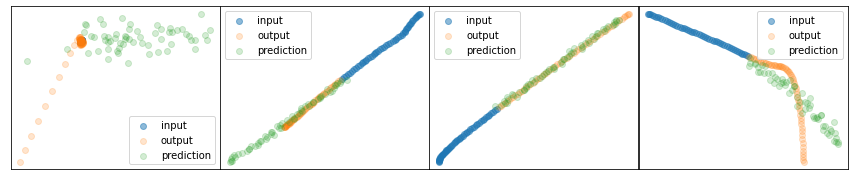

In [24]:
import matplotlib.pyplot as plt
import random


city = 'austin' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)
inpu , out = train_dataset[0]
batch_sz = 4
sample = {"austin":4}
def show_sample_batch(sample, sample_batch ):
    """visualize the trajectory for a batch of samples"""

    inp_for_test = get_input_tensor(sample, "train")
    
    inp,out = sample_batch 
    
    pred = model(inp_for_test.to(device).float()).cpu().detach().numpy().reshape(inp_for_test.shape[0],60,2)
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
   
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        
        axs[i].scatter(inp[i,:,0], inp[i,:,1], alpha=0.5)
        axs[i].scatter(out[i,:,0], out[i,:,1], alpha=0.2)
        
        axs[i].scatter(pred[i,:,0], pred[i,:,1], alpha=0.2)
        axs[i].legend(['input','output','prediction'])

        
for i_batch, sample_batch in enumerate(train_loader):
    
    inp, out = sample_batch
    show_sample_batch(sample,sample_batch)
    break

In [ ]:
# sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
# sub_df.to_csv('milstone.csv', index=None)

In [ ]:
# test_sub = pd.read_csv('milstone.csv')
# test_sub.head()